In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import metrics

red = "#E07182"
blue = "#4487D3"

In [2]:
def get_node_colors(sm, target):
    node_colors = []
    for node in sm.nodes():
        if node == target:
            node_colors.append(red)
        else:
            node_colors.append(blue)   
    return node_colors

## **Fenómeno a modelar**
    
**Rafa** y **Pipe** son dos colegas que viven en Valdivia, una ciudad del sur de Chile que suele tener mal clima. A pesar de esto, ellos gustan de salir después del trabajo a lanzar piedras y **romper ventanas** de casas abandonadas. Pipe suele salir más que Rafa a pesar del **mal clima**, pero de todas formas ambos tienden a salir menos si es que el clima no los favorece. Además de esto Pipe suele tener mejor puntería que Rafa

## **¿Como modelamos esto?**

### Variables:

- **Pipe**: será la variable binaria que dice si Pipe sale o no a romper ventanas
- **Rafa**: será la variable binaria que dice si Rafa sale o no a romper ventanas
- **MalClima**: será la variable binaria que nos dice si hay mal clima o no
- **RompeVentana**: será la variable binaria que nos dice si se rompen o no ventanas

### Distribuciones y relaciones:

\begin{align*}  
\textbf{MalClima} &\sim \text{Bernoulli}(0.8) \\  
\textbf{Pipe} &\sim \text{Bernoulli}(\textbf{MalClima}\cdot 0.70 + (1-\textbf{MalClima})\cdot 0.9) \\ 
\textbf{Rafa} &\sim \text{Bernoulli}(\textbf{MalClima}\cdot 0.40 + (1-\textbf{MalClima})\cdot 0.9) \\ 
\textbf{RompeVentana} &\sim \max\left\{\text{Bernoulli}(\textbf{Pipe}\cdot 0.90),  \text{Bernoulli}(\textbf{Rafa}\cdot 0.80)\right\}
\end{align*}

### Grafo causal del fenómeno

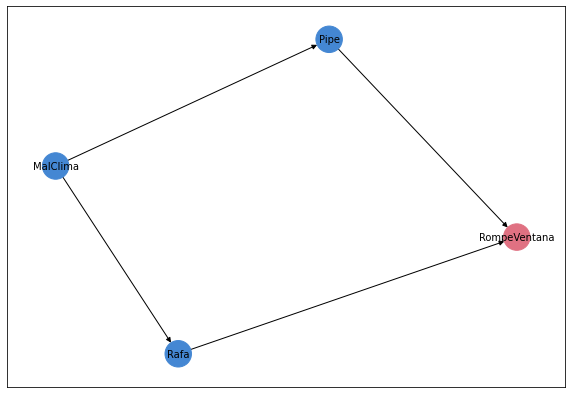

In [4]:
from causalnex.structure import StructureModel
import networkx as nx

target = "RompeVentana"

sm_teorico = StructureModel()
sm_teorico.add_edges_from([
    ('MalClima', 'Pipe'),
    ('MalClima', 'Rafa'),
    ('Pipe', 'RompeVentana'),
    ('Rafa', 'RompeVentana'),
])

fig, ax = plt.subplots(figsize=(10, 7))
nx.draw_networkx(
    sm_teorico, 
    node_color=get_node_colors(sm_teorico, target), 
    node_size=700, 
    font_size=10, 
    ax=ax
)

fig.show()

### Distribución conjunta

La función de probabilidad o distribución conjunta de las variables será denotada por
\begin{align*}  
p(\textbf{MalClima}, \textbf{Pipe}, \textbf{Rafa}, \textbf{RompeVentana}) 
\end{align*}
esta se puede explicitar utilizando el grafo causal o DAG de las variables. A este proceso se llama *factorización de la distribución* y para este caso tiene la siguiente forma

\begin{align*}  
p(\textbf{MalClima}, \textbf{Pipe}, \textbf{Rafa}, \textbf{RompeVentana}) 
&= p(\textbf{MalClima}) p(\textbf{Pipe}|\textbf{MalClima})  p(\textbf{Rafa}|\textbf{MalClima})  p(\textbf{RompeVentana}|\textbf{Pipe}, \textbf{Rafa})
\end{align*}

En un modelo de red bayesiana general la formula anterior se ve así:
\begin{align*}  
p(\bf{x_1, ..., x_n}) 
&= p(\bf{x_1}|\text{pa}(\bf{x_1})) p(\bf{x_2}|\text{pa}(\bf{x_2})) \cdots p(\bf{x_n}|\text{pa}(\bf{x_n}))
\end{align*}
donde pa(x_i) el conjunto de variables padres o ancentros de x_i definidos en el grafo causal

*Nota: El poder factorizar la probabilidad con un grafo poco denso hace que las posibles combinaciones a calcular sean menores*

### Generar datos sintéticos

In [6]:
import pyro
import torch as th
import pyro.distributions as dist

In [7]:
n_samples = 1000

MalClima = pyro.sample('MalClima', dist.Bernoulli(0.8*th.ones(n_samples)))
Pipe = pyro.sample('Pipe', dist.Bernoulli(MalClima*0.7 + (1-MalClima)*0.9))
Rafa = pyro.sample('Pipe', dist.Bernoulli(MalClima*0.4 + (1-MalClima)*0.9))
PipeRompe = pyro.sample('PipeRompe', dist.Bernoulli(Pipe*0.9))
RafaRompe = pyro.sample('RafaRompe', dist.Bernoulli(Rafa*0.8))
RompeVentana = th.maximum(PipeRompe, RafaRompe)

In [8]:
data = pd.DataFrame({
    'MalClima': MalClima.numpy(),
    'Pipe': Pipe.numpy(),
    'Rafa': Rafa.numpy(),
    'RompeVentana': RompeVentana.numpy(),
}).astype(int)

data.head()

,MalClima,Pipe,Rafa,RompeVentana
0,1,1,0,1
1,1,0,1,0
2,1,1,1,1
3,1,1,0,1
4,0,1,1,1


In [9]:
#sanity check de tasa de salida de rafa cuando hay mal clima
data.groupby('MalClima')['Rafa'].mean()

MalClima
0    0.892157
1    0.418342
Name: Rafa, dtype: float64

### Estimación del grafo causal
se usa el algoritmo NOTEARS:

https://proceedings.neurips.cc/paper/2018/file/e347c51419ffb23ca3fd5050202f9c3d-Paper.pdf

In [10]:
from causalnex.structure import notears

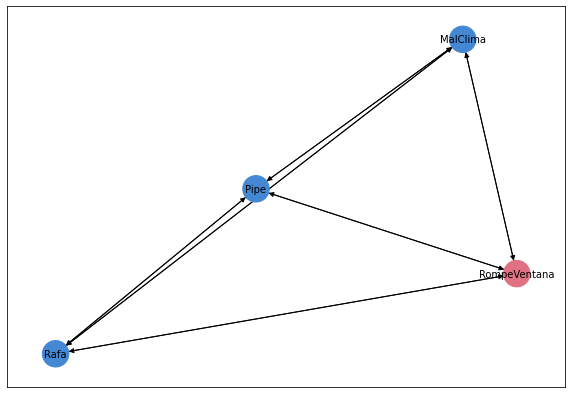

In [11]:
sm_notears = notears.from_pandas(data)

fig, ax = plt.subplots(figsize=(10, 7))
nx.draw_networkx(
    sm_notears, 
    node_color=get_node_colors(sm_notears, target), 
    node_size=700, 
    font_size=10, 
    ax=ax
)

fig.show()

In [12]:
graph = pd.DataFrame({
    (u, v, w, abs(w)) for u, v, w in sm_notears.edges(data="weight")
}, columns=['node_0', 'node_1', 'weight', 'abs_weight'])

graph.sort_values(by='abs_weight')

,node_0,node_1,weight,abs_weight
10,MalClima,RompeVentana,0.000006,0.000006
8,RompeVentana,Pipe,0.000025,0.000025
11,Pipe,Rafa,0.000029,0.000029
4,RompeVentana,Rafa,0.000070,0.000070
1,MalClima,Pipe,0.000082,0.000082
3,MalClima,Rafa,0.000209,0.000209
0,Rafa,MalClima,-0.095449,0.095449
7,Pipe,MalClima,0.206269,0.206269
2,Rafa,RompeVentana,0.345524,0.345524
6,RompeVentana,MalClima,0.630791,0.630791


está raro el grafo estimado! que la ventana se rompa o no, no debería influir en si pipe sale a tirar piedras

#### Restricciones

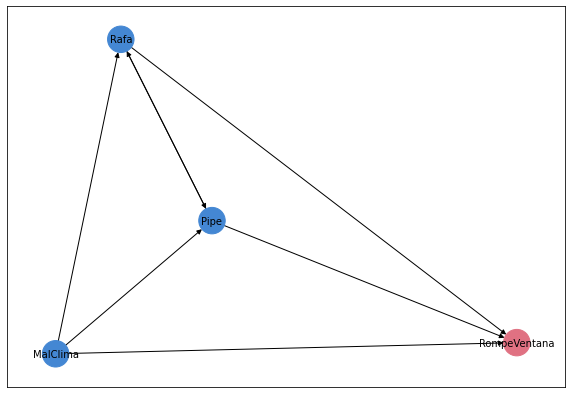

In [13]:
tabu_edges = [
    ('RompeVentana', 'Pipe'),
    ('RompeVentana', 'Rafa'), 
    ('Pipe', 'MalClima'),
    ('Rafa', 'MalClima'),
    ('RompeVentana', 'MalClima')
]

sm_notears = notears.from_pandas(data, tabu_edges=tabu_edges)

fig, ax = plt.subplots(figsize=(10, 7))
nx.draw_networkx(
    sm_notears, 
    node_color=get_node_colors(sm_notears, target), 
    node_size=700, 
    font_size=10, 
    ax=ax
)

fig.show()

In [14]:
graph = pd.DataFrame({
    (u, v, w, abs(w)) for u, v, w in sm_notears.edges(data="weight")
}, columns=['node_0', 'node_1', 'weight', 'abs_weight'])

graph.sort_values(by='abs_weight')

,node_0,node_1,weight,abs_weight
4,Rafa,Pipe,0.000216,0.000216
2,MalClima,Rafa,0.098818,0.098818
6,MalClima,RompeVentana,0.157977,0.157977
1,Rafa,RompeVentana,0.327815,0.327815
3,Pipe,Rafa,0.454699,0.454699
5,Pipe,RompeVentana,0.653728,0.653728
0,MalClima,Pipe,0.703124,0.703124


se puede hacer un triming del arbol usando un threshold de peso

In [15]:
sm_notears.remove_edges_below_threshold(0.000216)

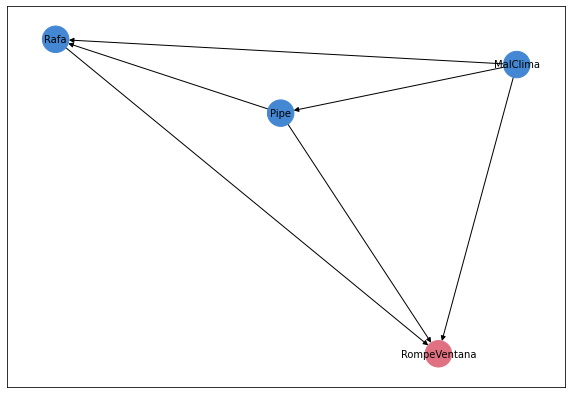

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
nx.draw_networkx(
    sm_notears, 
    node_color=get_node_colors(sm_notears, target), 
    node_size=700, 
    font_size=10, 
    ax=ax
)

fig.show()

### Entrenar modelo usando grafo teórico

In [17]:
from causalnex.network import BayesianNetwork

model = BayesianNetwork(sm_teorico)

/opt/conda/lib/python3.7/site-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


In [18]:
train = data.iloc[:900]
test = data.iloc[900:]

In [19]:
#extrae posibles valores (estados)que pueden tomar variables
model = model.fit_node_states(train) 

#fitear modelo
model = model.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [20]:
predictions = model.predict_probability(test, target)
predictions.head()

,RompeVentana_0,RompeVentana_1
900,0.103448,0.896552
901,0.266055,0.733945
902,0.266055,0.733945
903,0.103448,0.896552
904,0.103448,0.896552


In [21]:
def compute_pr_auc(target_values, prob_values):
    precision, recall, _ = metrics.precision_recall_curve(
        target_values, 
        prob_values,
    )
    return round(100*metrics.auc(recall, precision), 2)

In [22]:
compute_pr_auc(test['RompeVentana'], predictions['RompeVentana_1'])

96.81

In [23]:
from causalnex.evaluation import roc_auc

roc_auc(model, test, target)[-1]

0.9642999999999999

In [24]:
test.RompeVentana.mean()

0.78

### Preguntas contrafactuales

In [25]:
from causalnex.inference import InferenceEngine

In [39]:
ie = InferenceEngine(model)

### Margiales sin intervención

In [40]:
ie.query({})

{'MalClima': {0: 0.2139689578713969, 1: 0.786031042128603},
 'Pipe': {0: 0.25343962418992433, 1: 0.7465603758100756},
 'Rafa': {0: 0.48591937249942607, 1: 0.5140806275005738},
 'RompeVentana': {0: 0.2093940666843793, 1: 0.7906059333156206}}

#### ¿Que pasaria si siempre hay buen clima?

*Notamos que la estimación de **Pipe** y **Rafa** es muy precisa (ambas cerca de **0.9**)*

In [33]:
ie.do_intervention("MalClima", 0)
marginals_after_interventions = ie.query({})
marginals_after_interventions

{'MalClima': {0: 1.0, 1: 0.0},
 'Pipe': {0: 0.10309278350515463, 1: 0.8969072164948454},
 'Rafa': {0: 0.1134020618556701, 1: 0.88659793814433},
 'RompeVentana': {0: 0.05754096150591875, 1: 0.9424590384940813}}

In [34]:
ie.reset_do("MalClima")

#### ¿Que pasaria si siempre hay mal clima?

*Notamos que la estimación de **Pipe** y **Rafa** es muy precisa (ambas cerca de **Pipe~0.7** y **Rafa ~ 0.4**)*

In [35]:
ie.do_intervention("MalClima", 1)
marginals_after_interventions = ie.query({})
marginals_after_interventions

{'MalClima': {0: 0.0, 1: 0.9999999999999999},
 'Pipe': {0: 0.2943661971830986, 1: 0.7056338028169014},
 'Rafa': {0: 0.5873239436619717, 1: 0.4126760563380282},
 'RompeVentana': {0: 0.2507306665425498, 1: 0.7492693334574502}}

In [36]:
ie.reset_do("MalClima")

#### ¿Que pasaria si siempre Rafa sale a tirar piedras?

*Notamos que la probabilidad de romper ventana aumenta de 0.8 a 0.92 y que el clima no es afectado por esta intervención*

In [41]:
ie.do_intervention("Rafa", 1)
marginals_after_interventions = ie.query({})
marginals_after_interventions

{'MalClima': {0: 0.2139689578713969, 1: 0.786031042128603},
 'Pipe': {0: 0.25343962418992433, 1: 0.7465603758100756},
 'Rafa': {0: 0.0, 1: 1.0},
 'RompeVentana': {0: 0.07785571173072332, 1: 0.9221442882692766}}

In [42]:
ie.reset_do("Rafa")

#### ¿Que pasaria si siempre Pipe sale a tirar piedras?

*Notamos que la probabilidad de romper ventana aumenta de 0.8 a 0.94 y que el clima no es afectado por esta intervención*

In [43]:
ie.do_intervention("Pipe", 1)
marginals_after_interventions = ie.query({})
marginals_after_interventions

{'MalClima': {0: 0.2139689578713969, 1: 0.7860310421286031},
 'Pipe': {0: 0.0, 1: 0.9999999999999998},
 'Rafa': {0: 0.48591937249942607, 1: 0.5140806275005738},
 'RompeVentana': {0: 0.057447418325175, 1: 0.9425525816748248}}